In [1]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
tfd = tfp.distributions

In [2]:
import claude.utils as cu
import claude.tx as ctx
import claude.claudeflow.autoencoder as ae
import claude.claudeflow.helper as cfh
import claude.claudeflow.training as cft
import claude.claudeflow.models.NLIN as cfnlin

In [3]:
print('Tensorflow version:', tf.__version__)
print('Tensorflow probability version:', tfp.__version__)

Tensorflow version: 1.14.0
Tensorflow probability version: 0.7.0


In [4]:
seed = 42
tf.set_random_seed(seed)
np.random.seed(seed)

# Parameters
# Channel Parameters
chParam = cu.AttrDict()
chParam.M = 64
# chParam.SNR_db = 15
chParam.D		  = 16.4640
chParam.nPol	  = 2
chParam.PdBm	  = 0
chParam.nSpans	  = 20
chParam.channels = np.array([-100., -50., 0., 50., 100.])

# Auto-Encoder Parameters
aeParam = cu.AttrDict()
aeParam.temperature = 1
aeParam.nLayersEnc  = 1
aeParam.nLayersDec  = 2
aeParam.nHiddenEnc  = 128
aeParam.nHiddenDec  = 128
aeParam.activation  = tf.nn.relu
aeParam.dtype       = tf.float32
aeParam.cpx_dtype   = tf.complex64
aeParam.GN	        = False
aeParam.optimizeP   = True

# Training Parameters
trainingParam = cu.AttrDict()
trainingParam.nBatches      = 16
trainingParam.batchSize     = 32*chParam.M
trainingParam.learningRate  = 0.001
trainingParam.displayStep   = 5
trainingParam.iterations    = 30
trainingParam.path			= 'results_prop_nlin'
trainingParam.filename		= 'P{}_M{}_nSpans{}'.format(chParam.PdBm,chParam.M,chParam.nSpans)
trainingParam.summaries     = True

In [5]:
# create string identifier for tensorboard
if trainingParam.summaries:
    chHyperParam = ['M','PdBm','nSpans']
    aeHyperParam = ['GN']
    trainingHyperParam = ['nBatches','batchSize','learningRate']

    trainingParam.summaryString = ','.join(  [ '{}={}'.format(item,chParam[item]) for item in chHyperParam ]
                                            +[ '{}={}'.format(item,trainingParam[item]) for item in trainingHyperParam ]
                                            +[ '{}={}'.format(item,aeParam[item]) for item in aeHyperParam ] )

In [6]:
# TF constants
one = tf.constant(1, aeParam.dtype)
twoZeroCpx = tf.constant(2, aeParam.cpx_dtype)

In [7]:
from claude.models.NLIN import defaultParameters,\
                               calcConstants,\
                               calcIntraChannelNLIN,calcInterChannelNLIN,\
                               calcIntraChannelGN,calcInterChannelGN

In [8]:
# NLIN model
p = defaultParameters( D=chParam.D )
p.PdBm = chParam.PdBm
p.nSpans = chParam.nSpans
p.nPol = chParam.nPol
p.channels = chParam.channels
p.nChannels = len(chParam.channels)

aseNoisePower, interConst, intraConst, interConstAdd, intraConstAdd = calcConstants(p)

In [9]:
# Model constants to tensorflow
sigma2_noise = tf.constant( aseNoisePower, aeParam.dtype)
intra_const = tf.expand_dims( tf.constant( intraConst, aeParam.dtype), axis=1)
inter_const = tf.constant( interConst, aeParam.dtype)
intra_const_add = tf.constant( intraConstAdd, aeParam.dtype )
inter_const_add = tf.constant( interConstAdd, aeParam.dtype )

# learn optimal power or not
if aeParam.optimizeP:
    P0 = cu.dB2lin( chParam.PdBm, 'dBm')
    P0 = tf.constant(P0, aeParam.dtype)
    P0 = tf.contrib.distributions.softplus_inverse( P0 )
    P0 = tf.nn.softplus(tf.Variable( P0 ))    
else:
    P0 = tf.constant( cu.dB2lin( chParam.PdBm, 'dBm'), aeParam.dtype )
    
PdBm = cfh.lin2dB(P0, 'dBm')

W1120 17:58:02.031965 140459914934080 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1120 17:58:02.049019 140459914934080 deprecation.py:323] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/distributions/util.py:1196: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
def p_norm(p, x, fun=lambda x: tf.square(tf.abs(x))):
    return tf.reduce_sum(p * fun(x))

def r2c(x):
    return tf.cast(x, aeParam.cpx_dtype)

def c2r(x):
    return tf.cast(x, aeParam.dtype)

@tf.custom_gradient
def straight_through_estimator(s_bar):
    s = tf.one_hot(tf.math.argmax(s_bar, axis=-1), chParam.M)
    def grad(dy):
        return dy
    return s, grad

In [11]:
# Sampling
temperature = tf.constant(aeParam.temperature, aeParam.dtype)
enc_inp = tf.constant(1, dtype=aeParam.dtype, shape=(1,1))
s_logits = ae._encoder(enc_inp, aeParam.nHiddenEnc, aeParam.nLayersEnc, aeParam.activation, nOutput=chParam.M, name='encoder')
g_dist = tfd.Gumbel(loc=0., scale=1.)
g = g_dist.sample(sample_shape=[trainingParam.batchSize, chParam.M])
s_bar = tf.nn.softmax((g + s_logits)/temperature)

# straight through estimator
s = straight_through_estimator(s_bar)

W1120 17:58:02.135908 140459914934080 deprecation.py:506] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
# normalization & Modulation
p_s = tf.nn.softmax(s_logits)
constellation = tf.constant(ctx.qammod(chParam.M), aeParam.cpx_dtype)
norm_factor = tf.rsqrt(p_norm(p_s, constellation))
norm_constellation = r2c(norm_factor) * constellation
x = r2c(s) @ tf.transpose(norm_constellation) # @ is matmul

In [13]:
# NLIN or GN model
if aeParam.GN:
    sigma2_inter = cfnlin.calcInterChannelGN(inter_const,P0,chParam.nPol,dtype=aeParam.dtype)
    sigma2_intra = cfnlin.calcIntraChannelGN(intra_const,P0,chParam.nPol,dtype=aeParam.dtype)
    
    sigma2_nlin = tf.reduce_sum( sigma2_inter ) + tf.reduce_sum( sigma2_inter )
else:
    # kur = E[(X-mu)^4] / E[(X-mu)^2]^2
    # kur3 = E[(X-mu)^6] / E[(X-mu)^2]^3
    mu = p_norm(r2c(p_s), norm_constellation, fun=lambda x: x)
    constellation_abs = tf.abs(norm_constellation - mu)
    E2 = p_norm(p_s, constellation_abs, fun=lambda x: tf.pow(x, 2))
    E4 = p_norm(p_s, constellation_abs, fun=lambda x: tf.pow(x, 4))
    E6 = p_norm(p_s, constellation_abs, fun=lambda x: tf.pow(x, 6))

    kur   = E4 / tf.pow(E2, 2)
    kur3  = E6 / tf.pow(E2, 3)
    
    sigma2_inter = cfnlin.calcInterChannelNLIN(inter_const,kur,P0,chParam.nPol,dtype=aeParam.dtype)
    sigma2_intra = cfnlin.calcIntraChannelNLIN(intra_const,kur,kur3,P0,chParam.nPol,dtype=aeParam.dtype)
    
    sigma2_intra_add = cfnlin.calcIntraChannelNLIN(intra_const_add,kur,kur3,P0,chParam.nPol,dtype=aeParam.dtype)
    sigma2_inter_add = cfnlin.calcInterChannelNLINAddTerms(inter_const_add,kur,P0,chParam.nPol,dtype=aeParam.dtype)

    sigma2_nlin = tf.reduce_sum( sigma2_intra ) + tf.reduce_sum( sigma2_inter ) + tf.reduce_sum( sigma2_intra_add ) + tf.reduce_sum( sigma2_inter_add ) 

In [14]:
# checks
should_always_be_one = p_norm(p_s, norm_constellation)

# Channel
noise_cpx = tf.complex(tf.random_normal(shape=tf.shape(x), dtype=aeParam.dtype),
                       tf.random_normal(shape=tf.shape(x), dtype=aeParam.dtype))
sigma2 = sigma2_noise + sigma2_nlin
noise_snr = r2c(tf.sqrt(sigma2)) * tf.rsqrt(twoZeroCpx) * noise_cpx

y = r2c(tf.rsqrt(P0)) * (r2c(tf.sqrt(P0)) * x + noise_snr)

# demodulator
y_vec = cfh.complex2real(tf.squeeze(y))
dec = ae._encoder(y_vec, aeParam.nHiddenDec, aeParam.nLayersDec, aeParam.activation, nOutput=chParam.M, name='decoder')

In [15]:
# loss
loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.stop_gradient(s), logits=dec)
entropy_S = -p_norm(p_s, p_s, lambda x: cfh.log2(x))
loss_hat = loss - entropy_S

gaussian_MI = cfh.gaussianMI(x, y, norm_constellation, chParam.M, dtype=aeParam.dtype)

optimizer = tf.train.AdamOptimizer(learning_rate=trainingParam.learningRate).minimize(loss_hat)

metricsDict = {'loss_hat': loss_hat, 'gaussian_MI_metric': gaussian_MI}
meanMetricOpsDict, updateOps, resetOps = cft.create_mean_metrics(metricsDict)

In [16]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [17]:
# summaries for tensorboard
if trainingParam.summaries:
    # Summaries
    s = [tf.summary.scalar('xentropy', meanMetricOpsDict['loss_hat']),
         tf.summary.scalar('gaussian_MI_metric', meanMetricOpsDict['gaussian_MI_metric']),
         tf.summary.scalar('Plin', P0),
         tf.summary.scalar('PdBm', PdBm),
         tf.summary.scalar('sigma2_noise', sigma2_noise),
         tf.summary.scalar('sigma2_nlin', sigma2_nlin)]

    if not aeParam.GN:
        s.extend( [tf.summary.scalar('real_mu', tf.real(mu)),
                   tf.summary.scalar('imag_mu', tf.imag(mu)),
                   tf.summary.scalar('kur', kur),
                   tf.summary.scalar('kur3', kur3)] )

    summaries = tf.summary.merge_all()

    summaries_dir = os.path.join(trainingParam.path,'tboard',trainingParam.summaryString)
    os.makedirs(summaries_dir, exist_ok=True)

    train_writer = tf.summary.FileWriter(summaries_dir + '/train', sess.graph)
else:
    train_writer = None

# save process
saver = tf.train.Saver()
checkpoint_path = os.path.join(trainingParam.path,'checkpoint',trainingParam.filename,'best')
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
else:
    pass
    #print("Restoring checkpoint...", flush=True)
    #saver.restore(sess=sess,save_path=checkpoint_path)

In [18]:
bestLoss = 1e9
for epoch in range(1, trainingParam.iterations+1):
    sess.run(resetOps)
    for batch in range(0,trainingParam.nBatches):
        sess.run([optimizer, updateOps])

    [outLossHat, outGaussianMI, outShouldAlwaysBeOne] = sess.run([meanMetricOpsDict['loss_hat'],
                                                              meanMetricOpsDict['gaussian_MI_metric'],
                                                              should_always_be_one])
    [outPdBm, outKur, outKur3] = sess.run([PdBm, kur, kur3])
    
    if trainingParam.summaries:
        outSummaries = sess.run(summaries)
        train_writer.add_summary(outSummaries, epoch)
    
    avLoss = outLossHat
    if avLoss < bestLoss:
        bestLoss = avLoss
        lastImprovement = epoch
        saver.save(sess=sess,save_path=checkpoint_path)

    if epoch%trainingParam.displayStep == 0:
        print('epoch: {} - lossHat: {:.3} - gaussianMI: {:.3} - always 1: {:.2}'.format(epoch, outLossHat, outGaussianMI, outShouldAlwaysBeOne))
        print('\t PdBm: {:.3} - kur: {:.3} - kur3: {:.3}'.format(outPdBm, outKur, outKur3))

epoch: 5 - lossHat: -3.43 - gaussianMI: 4.57 - always 1: 1.0
	 PdBm: 0.262 - kur: 1.42 - kur3: 2.38
epoch: 10 - lossHat: -4.28 - gaussianMI: 4.57 - always 1: 1.0
	 PdBm: 0.273 - kur: 1.41 - kur3: 2.35
epoch: 15 - lossHat: -4.72 - gaussianMI: 4.58 - always 1: 1.0
	 PdBm: 0.271 - kur: 1.41 - kur3: 2.36
epoch: 20 - lossHat: -4.89 - gaussianMI: 4.59 - always 1: 1.0
	 PdBm: 0.266 - kur: 1.42 - kur3: 2.38
epoch: 25 - lossHat: -4.95 - gaussianMI: 4.6 - always 1: 1.0
	 PdBm: 0.265 - kur: 1.42 - kur3: 2.38
epoch: 30 - lossHat: -4.97 - gaussianMI: 4.6 - always 1: 1.0
	 PdBm: 0.263 - kur: 1.43 - kur3: 2.4


In [19]:
# evaluation
sess.run(resetOps)
for batch in range(0, 1000):
    sess.run(updateOps)

outGaussianMI = sess.run(meanMetricOpsDict['gaussian_MI_metric'])
print('Final MI: {:.3}'.format(outGaussianMI))

Final MI: 4.59


In [20]:
np_x = []
np_y = []
for _ in range(1000):
    temp_x, temp_y = sess.run([x, y])
    np_x.append(temp_x)
    np_y.append(temp_y)

In [21]:
all_y = np.reshape(np.stack(np_y),-1)
all_x = np.reshape(np.stack(np_x),-1)

noise = np.random.normal(0,1,size=all_x.shape)+1j*np.random.normal(0,1,size=all_x.shape) 
all_x = all_x + 0.05*noise

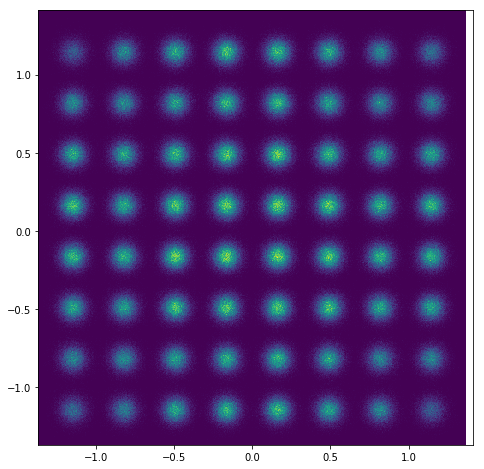

In [22]:
heatmap, xedges, yedges = np.histogram2d(np.real(all_x), np.imag(all_x), bins=500)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(8,8))
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.axis('square');